In [43]:
from matplotlib import pyplot as plt
import numpy as np
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import os
import random

In [44]:
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 1, 0, 0, 1, 0, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

49A95.jpg


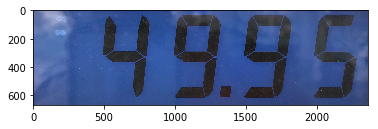

In [45]:
#pick a random image from the Test directory
image = str(random.choice(os.listdir("Test/")))
print(image)
image = cv2.imread("Test/" + image)
plt.imshow(image)
plt.show()

#uncomment to test a specific file
#image = cv2.imread("Test/7A00.jpg")

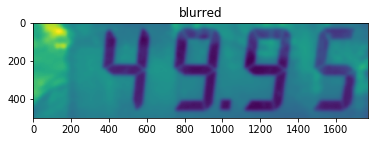

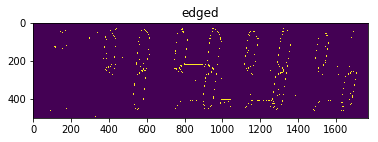

In [46]:
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (55, 55), 0)
edged = imutils.auto_canny(gray)
#edged = cv2.Canny(blurred, 17, 17, 255)

plt.imshow(blurred)
plt.title('blurred')
plt.show()
plt.imshow(edged)
plt.title('edged')
plt.show()

In [47]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [48]:
displayCnt = None

In [49]:
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if the contour has four vertices, then we have found
    # the thermostat display
    if len(approx) == 4:
        displayCnt = approx
        break

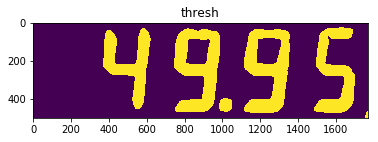

In [50]:
thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(thresh)
plt.title('thresh')
plt.show()

In [51]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
digitCnts = []

In [52]:
for c in cnts:
    (x,y,w,h) = cv2.boundingRect(c)
    print(w,h)

15 37
70 69
246 443
246 442
252 430
219 451


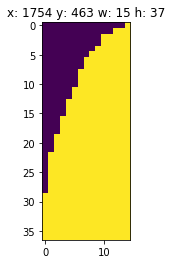

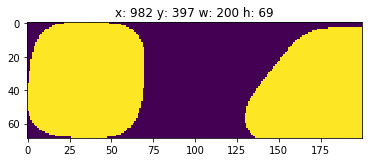

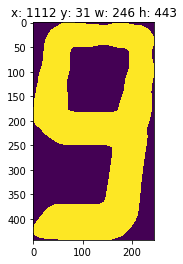

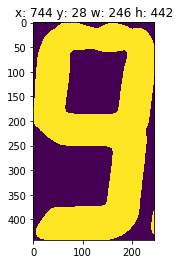

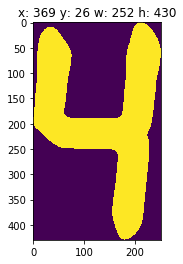

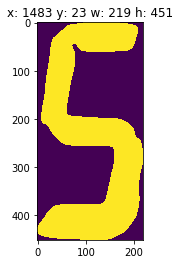

In [53]:
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    if (w < 100 and w > 50):
        supp = 200 - w
        w = w + supp
    roi = thresh[y:y + h, x:x + w]
    plt.imshow(roi)
    plt.title('x: ' + str(x) + ' y: ' + str(y) + ' w: ' + str(w) + ' h: ' + str(h))
    plt.show()

    # if the contour is sufficiently large, it must be a digit
    if w >= 50 and h >= 300:
        digitCnts.append(c)

In [54]:
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

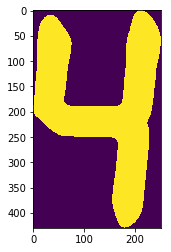

x: 369 y: 26 w: 252 h: 430
4
[0, 1, 1, 1, 0, 1, 0]


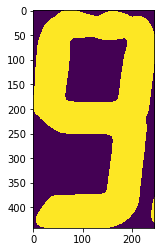

x: 744 y: 28 w: 246 h: 442
9
[1, 1, 1, 1, 0, 1, 1]


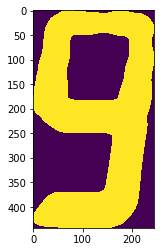

x: 1112 y: 31 w: 246 h: 443
9
[1, 1, 1, 1, 0, 1, 1]


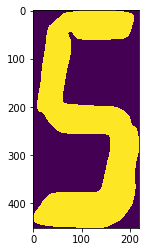

x: 1483 y: 23 w: 219 h: 451
5
[1, 1, 0, 1, 0, 1, 1]


In [55]:
digits = []
for c in digitCnts:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    if (w < 100 and w > 50):
        supp = 200 - w
        w = w + supp
    roi = thresh[y:y + h, x:x + w]
    plt.imshow(roi)
    plt.show()
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)

    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)

    # loop over the segments
    try:
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
            # extract the segment ROI, count the total number of
            # thresholded pixels in the segment, and then compute
            # the area of the segment
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)

            # if the total number of non-zero pixels is greater than
            # 50% of the area, mark the segment as "on"
            if total / float(area) > 0.5:
                on[i]= 1

        # lookup the digit and draw it on the image
        print('x: ' + str(x) + ' y: ' + str(y) + ' w: ' + str(w) + ' h: ' + str(h))
        digit = DIGITS_LOOKUP[tuple(on)]
        print(digit)
        print(on)
        digits.append(digit)
    except:
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
            # extract the segment ROI, count the total number of
            # thresholded pixels in the segment, and then compute
            # the area of the segment
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)

            # if the total number of non-zero pixels is greater than
            # 50% of the area, mark the segment as "on"
            if total / float(area) > 0.4:
                on[i]= 1

        # lookup the digit and draw it on the image
        print('x: ' + str(x) + ' y: ' + str(y) + ' w: ' + str(w) + ' h: ' + str(h))
        digit = DIGITS_LOOKUP[tuple(on)]
        print(digit)
        print(on)
        digits.append(digit)

In [56]:
print("".join(str(x) for x in digits))

4995
